# MOLE DETECTION  -- Binary --

#### Import Necessary Libraries

In [ ]:
import os
import numpy as np
import pandas as pd

from PIL import Image
from glob import glob
import itertools
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#### Define default variables

In [29]:
# DATA_DIR = os.path.join('.', 'data')
# IMAGE_DIR = os.path.join('.', 'data\\images\\')
# PATHS ARE ALREADY IN CSV
#All images are 640 x 480  
# 2	    3	    4	5
# 300	200	150	    120
# 225	150	112.5	90

XPIXEL=120
YPIXEL=90


label_mapping = {
    0: 'benign',
    1: 'malignant'
}


label_bm = {
     'akiec':'benign',
     'bcc':'malignant',
     'bkl':'benign',
     'df':'benign',
     'mel':'malignant',
     'nv':'benign',
     'vasc':'benign'
}

int_label_mapping = dict((value, key) for key, value in label_mapping.items())
type_label_mapping = dict((value, key) for value, key in label_bm.items())

#### Import the data 

In [24]:
data = pd.read_csv('data/HAM10000_metadata.csv')
data.head(5)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [25]:

data['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [33]:
#Convert type to benign or malignant according to type label
data['bm'] = data['dx'].map(type_label_mapping.get)
data['path'] = './data/HAM10000_images/' + data['image_id'] +".jpg"

In [38]:
# Read image pixel data 
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((XPIXEL,YPIXEL))))

In [34]:
# Converting labels to 0 and 1
data['label'] = data['bm'].map(int_label_mapping.get)


In [53]:
data['label'].value_counts()

0    8388
1    1627
Name: label, dtype: int64

In [55]:
#resampling
n_samples=4500


from sklearn.utils import resample
print(data['label'].value_counts())

# Balancing the data
# tried balancing with class weights and imageprocessing best results came with resampling


df_0 = data[data['label'] == 0]
df_1 = data[data['label'] == 1]



df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 


#Combined back to a single dataframe
data_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                             ])

print(data_balanced['label'].value_counts())

0    8388
1    1627
Name: label, dtype: int64
0    4500
1    4500
Name: label, dtype: int64


In [56]:
data=data_balanced

### Create X , Y

In [57]:
#data = data.sample(frac = 1)
# ORIGINAL
# Convert image pixel columnm into numpy array
X = data['image_pixel'].to_numpy()
X = np.stack(X, axis=0)
Y = np.array(data['label'])
Y = np.stack(Y,axis=0)   # no need
print(X.shape)
print(Y.shape)

(9000, 90, 120, 3)
(9000,)


In [58]:
def train_test(X, Y):
    # train test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42,shuffle=True)
    
    return X_train, X_test, Y_train, Y_test

In [59]:
def create_model():
    model = Sequential()
    
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (YPIXEL, XPIXEL, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    #model.add(Dense(8, activation='relu'))
    

    model.add(Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #### learnign rate???? 

    model.compile(loss = 'binary_crossentropy',
                 optimizer = "adam",
                  metrics = ['accuracy'])
    print(model.summary())
    return model

In [42]:
def train_model(model:Sequential, X_tr, Y_tr, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1,mode='auto')
                               
    
    learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')
    
    history = model.fit(X_tr, Y_tr, validation_split=0.2, batch_size = 24, epochs = EPOCHS,callbacks = [learning_rate, early_stop])
    return history

In [43]:
def test_model(model:Sequential, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred=np.round(y_pred,0)
    #y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    cm=confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm,label_mapping,"44")
    print(cm)

    plt.show() 

In [44]:
def plot_confusion_matrix(cm, classes, name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

   
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('_confusion_matrix.png', dpi=300)

### Create train and test datas for original and augumented datasets

In [60]:
# For Original Dataset
X_train, X_test, Y_train, Y_test = train_test(X, Y)
#Augemented dataset
#X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = train_test(X_aug, Y_aug)
print(X_train.shape)
#print(X_train_aug.shape)



(7200, 90, 120, 3)


### Create the Model

In [61]:
model = create_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 90, 120, 16)       448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 60, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 60, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 23, 30, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 15, 64)      

In [62]:
model_history = train_model(model, X_train, Y_train, 50)

Epoch 1/50
240/240 [==============================] - 8s 31ms/step - loss: 0.9784 - accuracy: 0.6672 - val_loss: 0.5369 - val_accuracy: 0.7028 - lr: 0.0010
Epoch 2/50
240/240 [==============================] - 7s 31ms/step - loss: 0.5221 - accuracy: 0.7203 - val_loss: 0.5380 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 3/50
240/240 [==============================] - 8s 31ms/step - loss: 0.4998 - accuracy: 0.7316 - val_loss: 0.5036 - val_accuracy: 0.7319 - lr: 0.0010
Epoch 4/50
240/240 [==============================] - 7s 31ms/step - loss: 0.4926 - accuracy: 0.7444 - val_loss: 0.5037 - val_accuracy: 0.7618 - lr: 0.0010
Epoch 5/50
240/240 [==============================] - 8s 32ms/step - loss: 0.4607 - accuracy: 0.7675 - val_loss: 0.4357 - val_accuracy: 0.7646 - lr: 0.0010
Epoch 6/50
240/240 [==============================] - 7s 31ms/step - loss: 0.4395 - accuracy: 0.7741 - val_loss: 0.4334 - val_accuracy: 0.7785 - lr: 0.0010
Epoch 7/50
240/240 [==============================] - 7s 30ms/st

#### Loss and accuracy curves for training and test sets.

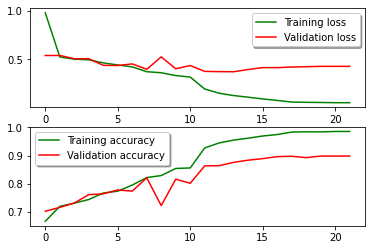

In [63]:
g, ax = plt.subplots(2,1)
ax[0].plot(model_history.history['loss'], color='g', label="Training loss")
ax[0].plot(model_history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(model_history.history['accuracy'], color='g', label="Training accuracy")
ax[1].plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Saving the model for deployment 

In [ ]:
model_json = model.to_json()
with open("modelbm.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("modelbm.h5")

### Test Model

Test Accuracy: 88.167%
57/57 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

      benign       0.92      0.83      0.87       884
   malignant       0.85      0.93      0.89       916

    accuracy                           0.88      1800
   macro avg       0.89      0.88      0.88      1800
weighted avg       0.89      0.88      0.88      1800

[[731 153]
 [ 60 856]]


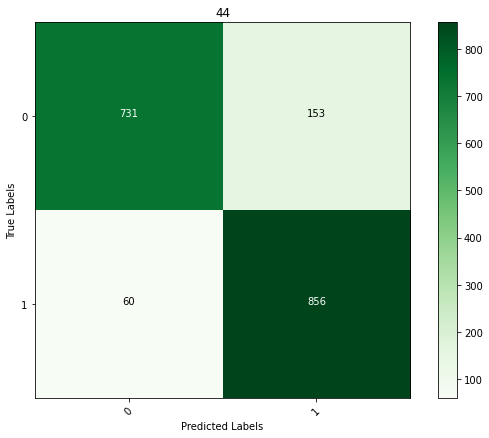

In [64]:
test_model(model, X_test, Y_test)

### Prediction for only one image

In [65]:
def predict_one_image(image_nr):

    predict_only_one = data.iloc[image_nr]
    print("Imid :" ,predict_only_one.image_id)
    print("Real :" ,predict_only_one.bm)
    
    new_one = predict_only_one.image_pixel.reshape((1,90,120,3))
    preds=model.predict(new_one)[0][0]
    
    max_index_col = np.round(preds,0)

    if preds<0.5:
        preds=1-preds
        

    pred_probabilty = " % {:.2f}".format(preds*100)
    preds=np.round(preds,0)
       
    result=label_mapping.get(max_index_col) + pred_probabilty
    print("Pred :", result)

    sample_data = predict_only_one['image_pixel']
    plt.figure(figsize=(10, 10))
    plt.imshow(sample_data)
    plt.axis("off")
    plt.show() 


Imid : ISIC_0034230
Real : benign
1/1 [==============================] - 0s 20ms/step
Pred : malignant % 83.93


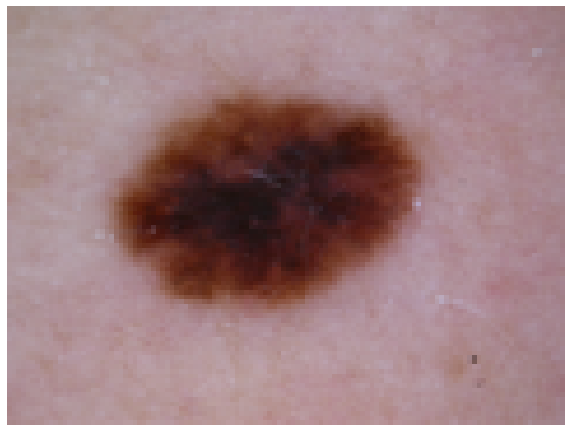

In [106]:
predict_one_image(81)